In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных 
import matplotlib.pyplot as plt #для визуализации 
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё 
from sklearn import tree #деревья решений 
from sklearn import ensemble #ансамбли 
from sklearn import metrics #метрики 
from sklearn import preprocessing #предобработка 
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline plt.style.use('seaborn')

UsageError: unrecognized arguments: plt.style.use('seaborn')


## Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## Знакомство с данными и их исследование

In [2]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [3]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

## Оптимизация гиперпараметров модели¶

### Логистическая регрессия

In [5]:
#Создаем объект класса логистическая регрессия 
log_reg = linear_model.LogisticRegression(max_iter = 1000) 
#Обучаем модель, минимизируя logloss 
log_reg.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test))) 
y_test_pred = log_reg.predict(X_test) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


<center><b>GridSearchCV - Логистическая регрессия</b>

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации 
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации 
             } 
grid_search = GridSearchCV( 
    estimator=linear_model.LogisticRegression( 
        random_state=42, #генератор случайных чисел 
        max_iter=1000 #количество итераций на сходимость 
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1 
)
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred))) 
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 15.5 s
Wall time: 9min 47s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


*С помощью метода GridSearchCV и использования маленькой сетки гиперпараметров  не получилось улучшить значения f1_score на тестовом наборе*

#### Расширим сетку гиперпараметров.

In [11]:
param_grid = [ 
              {'penalty': ['l2', 'none'] , # тип регуляризации 
               'solver': ['lbfgs', 'sag'], # алгоритм оптимизации 
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 1]}, # уровень силы регурялизации

              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 1]}
] 
grid_search_1 = GridSearchCV( 
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1 
)
%time grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred))) 
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 2.2 s
Wall time: 1h 4min 56s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


*После расширения сетки гиперпараметров с помощью метода GridSearchCV получилось улучшить значения f1_score на тестовом наборе до значения 0.79*

<center><b>RandomizedSearchCV - Логистическая регрессия

In [155]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 1min 26s
Wall time: 6min 46s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.12}


*С помощью метода RandomizedSearchCV получилось улучшить значения f1_score на тестовом наборе до значения 0.79 значительно быстрее, чем с использованием метода GridSearchCV*

#### <center> Hyperopt - Логистическая регрессия

In [6]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l1', 'l2']),
       'solver' : hp.choice('solver', ['liblinear', 'saga']),
       'C': hp.uniform('C', 0.01, 1)
      }

In [7]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': float(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=2000)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [8]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|████████████████████████████████████████████████████████████████████████████| 20/20 [59:19:12<00:00, 10677.61s/trial, best loss: -0.7821505333819923]
Наилучшие значения гиперпараметров {'C': 0.05303073575736464, 'penalty': 1, 'solver': 0}
CPU times: total: 19min 51s
Wall time: 2d 11h 19min 12s


In [9]:
# Поменяем в словаре best значения метода регуляризации c цифр на строковые данные
if best['penalty'] == 0:
    best.update({'penalty':'l1'})
else:
    best.update({'penalty':'l2'})

# Поменяем в словаре best значения численного метода оптимизации функции потерь c цифр на строковые данные
if best['solver'] == 0:
    best.update({'solver':'liblinear'})
else:
    best.update({'solver':'saga'})

In [10]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=best['penalty'],
    solver=best['solver'],
    C=best['C']
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.84
f1_score на тестовом наборе: 0.80


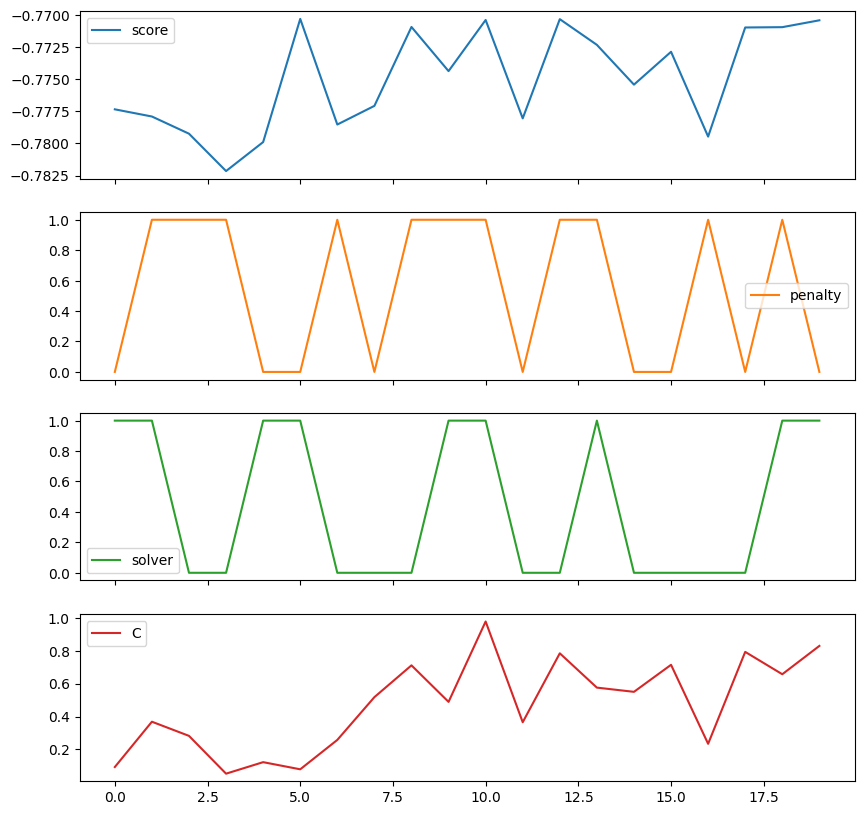

In [11]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['penalty'][0],
                      x['misc']['vals']['solver'][0],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'penalty', 'solver', 'C'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

*С помощью метода  с помощью метода Hyperopt получилось улучшить значения f1_score на тестовом наборе до значения 0.8*

<center><b>OPTUNA - Логистическая регрессия

In [189]:
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', 0.01, 1, step=None,log=False)
  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [190]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-06-07 16:20:24,719] A new study created in memory with name: LogisticRegression
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-06-07 16:20:45,418] Trial 0 finished with value: 0.8672782874617738 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.6291956579169583}. Best is trial 0 with value: 0.8672782874617738.
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-06-07 16:21:07,101] Trial 1 finished with value: 0.868421052631579 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.7021195844653394}. Best is trial 1 with value: 0.868421052631579.
[I 2024-06-07 16:21:08,287] Trial 2 finished with value: 0.8588844864370618 and parameters: {'pena

CPU times: total: 2min 35s
Wall time: 2min 50s


In [192]:
# выводим результаты на обучающей выборке
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9994150702040144}


*С помощью метода OPTUNA не получилось улучшить значения f1_score на тестовом наборе.  Возможно необходимо увеличение сетки гиперпараметров*

### **Дерево решений**

In [214]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


<center><b>GridSearchCV -  Дерево решений</b>

In [215]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 6.31 s
Wall time: 3min 8s
f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


*После расширения сетки гиперпараметров с помощью метода GridSearchCV получилось улучшить значения f1_score на тестовом наборе до значения 0.82*

<center><b>RandomizedSearchCV -  Дерево решений

In [216]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.95 s
Wall time: 1min 13s
f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 37}


*С помощью метода RandomizedSearchCV получилось улучшить значения f1_score на тестовом наборе до значения 0.82 значительно быстрее, чем с использованием метода GridSearchCV*

#### <center> Hyperopt - Дерево решений

In [255]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [256]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [257]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.44s/trial, best loss: -0.9825528007346188]
Наилучшие значения гиперпараметров {'max_depth': 15.0, 'min_samples_leaf': 2.0, 'n_estimators': 146.0}
CPU times: total: 2min 14s
Wall time: 2min 28s


In [258]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров {}".format(best))

f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров {'max_depth': 15.0, 'min_samples_leaf': 2.0, 'n_estimators': 146.0}


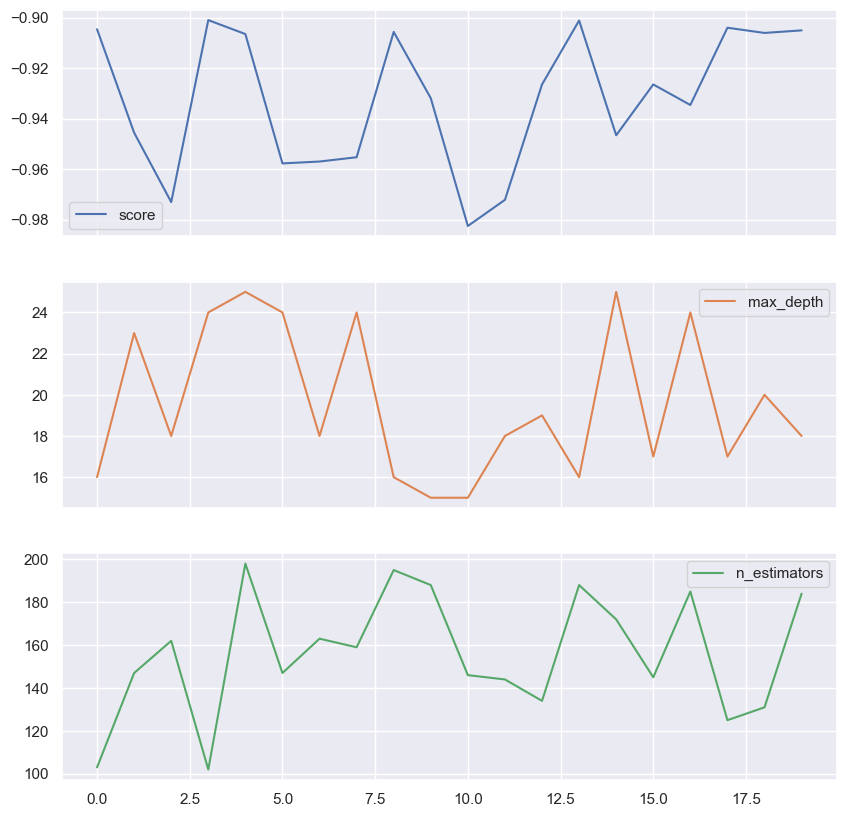

In [259]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

*С помощью метода Hyperopt получилось улучшить значения f1_score на тестовом наборе до значения 0.83*

<center><b>OPTUNA - Дерево решений

In [232]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [233]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-06-07 18:20:15,669] A new study created in memory with name: RandomForestClassifier
[I 2024-06-07 18:20:20,926] Trial 0 finished with value: 0.9282442748091603 and parameters: {'n_estimators': 117, 'max_depth': 21, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9282442748091603.
[I 2024-06-07 18:20:27,922] Trial 1 finished with value: 0.9529339853300732 and parameters: {'n_estimators': 141, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9529339853300732.
[I 2024-06-07 18:20:35,737] Trial 2 finished with value: 0.9758039816232772 and parameters: {'n_estimators': 134, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9758039816232772.
[I 2024-06-07 18:20:40,629] Trial 3 finished with value: 0.9360660752523707 and parameters: {'n_estimators': 102, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9758039816232772.
[I 2024-06-07 18:20:44,619] Trial 4 finished with value: 0.8827331486611265 and parameters: {'n_

CPU times: total: 2min 20s
Wall time: 2min 37s


In [234]:
# выводим результаты на обучающей выборке
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

f1_score на обучающем наборе: 0.99


In [236]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров {'n_estimators': 168, 'max_depth': 30, 'min_samples_leaf': 2}


*С помощью метода OPTUNA получилось улучшить значения f1_score на тестовом наборе до значения 0.82*

*Вывод: в результате подбора гиперпараметров с помощью базовых и продвинутых методов оптимизации для логистической регрессии и случайного леса метод Hyperopt с использование кросс-валидации показал наилучший результат f1_score на тестовом наборе в обеих моделях*